## Phase 1: Reddit Stock Sentiment Analysis
This notebook follows the process from the DM2025 Lab1 Master file, applying it to the new `Reddit-stock-sentiment.csv` dataset.

### 1. Data Loading and Initial Exploration
First, we'll import the necessary libraries and load our dataset into a pandas DataFrame. Then, we'll take a quick look at its structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
from sklearn.feature_extraction.text import CountVectorizer

# load dataset
df = pd.read_csv('newdataset/Reddit-stock-sentiment.csv')

# check first few rows
df.head()

,type,datetime,post_id,subreddit,title,author,url,upvotes,downvotes,upvote_ratio,text,subjectivity,polarity,sentiment,entities,label
0,comment,2025-04-11 17:29:56,mmli62w,wallstreetbets,Retardation is on the menu boys! WSB is so back,StickyTip420,https://i.redd.it/0yq2ftren8ue1.jpeg,0,NaN,NaN,Calls on retards,1.000000,-0.900000,-1.0,[],-1.0
1,comment,2025-04-12 1:12:19,mmnu7v9,wallstreetbets,Retail giant TARGET has now declined for 10 co...,Comfortable-Dog-8437,https://i.redd.it/7tl6puv9waue1.jpeg,-15,NaN,NaN,Stunt as in like why did they even make a big ...,0.177778,0.083333,1.0,"['Stunt', 'company', 'deal', 'place']",0.0
2,comment,2025-04-10 15:09:41,mmeevio,StockMarket,How do you feel about a sitting president maki...,Btankersly66,https://apnews.com/article/trump-truth-social-...,1,NaN,NaN,Seeing lots of red in the ticker.,0.000000,0.000000,0.0,['ticker'],0.0
3,post,2023-08-30 17:12:55,165kllm,stockstobuytoday,Who knows more? $VMAR,emiljenfn,https://www.reddit.com/r/stockstobuytoday/comm...,30,0.0,0.98,Vision Marine Technologies Inc. is rewriting t...,0.646970,0.216383,1.0,"['watercraft', 'skill', 'power', ']', 'feat', ...",1.0
4,comment,2025-04-11 14:48:05,mmkl6bw,StockMarket,The Trump administration is begging Xi Jinping...,Just-Big6411,https://edition.cnn.com/2025/04/10/politics/tr...,1,NaN,NaN,He didn’t say thank you.,0.000000,0.000000,0.0,[],-1.0


In [2]:
# dataset summary
df.info()

# shape
print("\n### Dataset Shape ###")
print(f"{df.shape}")

print(f"\n\n{'-'*85}\n")

# statistic description
print(df.describe())

print(f"\n\n{'-'*85}\n")

# distribution of label
print(df['label'].value_counts())

print(f"\n\n{'-'*85}\n")

# check which subreddit are most data comes from
print(df['subreddit'].value_counts().head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          847 non-null    object 
 1   datetime      847 non-null    object 
 2   post_id       847 non-null    object 
 3   subreddit     847 non-null    object 
 4   title         847 non-null    object 
 5   author        847 non-null    object 
 6   url           847 non-null    object 
 7   upvotes       847 non-null    int64  
 8   downvotes     64 non-null     float64
 9   upvote_ratio  64 non-null     float64
 10  text          847 non-null    object 
 11  subjectivity  847 non-null    float64
 12  polarity      847 non-null    float64
 13  sentiment     847 non-null    float64
 14  entities      847 non-null    object 
 15  label         847 non-null    float64
dtypes: float64(6), int64(1), object(9)
memory usage: 106.0+ KB

### Dataset Shape ###
(847, 16)


----------------------

### 2. Data Cleaning
Real-world data is often messy. We need to handle missing values and duplicates to ensure our analysis is accurate.

In [ ]:
print(f"Original rows: {len(df)}")

# check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# drop columns that are not useful
columns_to_drop = ['downvotes', 'upvote_ratio']
df.drop(columns=columns_to_drop, inplace=True)

# drop rows where text or label columns are empty
df.dropna(subset=['text', 'label'], inplace=True)

print(f"\nrows after dropping some: {len(df)}")

# check and remove duplicate posts based on text
num_duplicates = df.duplicated(subset=['text']).sum()
print(f"duplicate text entries: {num_duplicates}")
df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print(f"after removing duplicates: {len(df)}")

Original rows: 847
Missing values before cleaning:
type              0
datetime          0
post_id           0
subreddit         0
title             0
author            0
url               0
upvotes           0
downvotes       783
upvote_ratio    783
text              0
subjectivity      0
polarity          0
sentiment         0
entities          0
label             0
dtype: int64

 rows after dropping some: 847
duplicate text entries: 23
after removing duplicates: 824


when we checked for missing values, the downvotes and upvote_ratio columns was missing 783 values, but we only have 847 rows in total

If we dropped every row that had any missing value, we would of lost almost all our data. We gonna have like 64 rows left, which is not enough to do anything useful

those two columns are not very important for our main goal, which is to analyze the text sentiment from the text and labelcolumns. So, it make more sense to just get rid of those two columns and keep all the rows that still has text data.

sometimes same post is just spam or from a bot. its a good decision to remove these types of data also. it can skew our results if we dont.

### 3. Data Transformation
To make the sentiment labels easier to understand, we'll add a new column with human-readable names ('Positive', 'Neutral', 'Negative').

In [4]:
# Function to map numeric labels to names
def map_sentiment(label):
    if label == 1.0:
        return 'Positive'
    elif label == 0.0:
        return 'Neutral'
    else: # -1.0
        return 'Negative'

# Create the new 'sentiment_name' column
df['sentiment_name'] = df['label'].apply(map_sentiment)

# Display the text and new sentiment name side-by-side
df[['text', 'sentiment_name']].head()

,text,sentiment_name
0,Calls on retards,Negative
1,Stunt as in like why did they even make a big ...,Neutral
2,Seeing lots of red in the ticker.,Neutral
3,Vision Marine Technologies Inc. is rewriting t...,Positive
4,He didn’t say thank you.,Negative


### 4. Data Visualization
A bar chart is a great way to see the distribution of sentiments in our dataset.

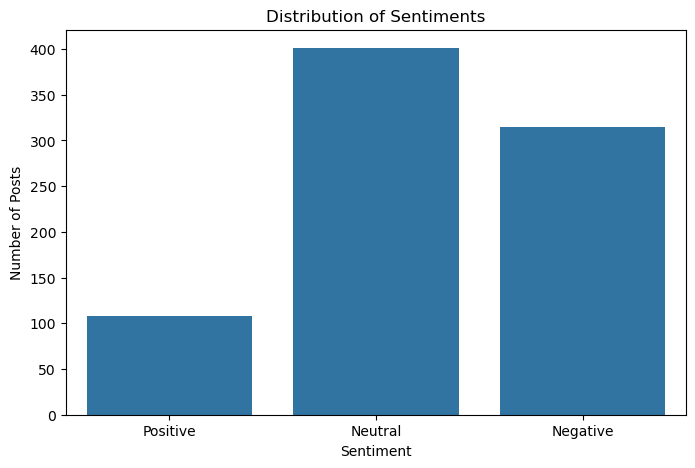

In [5]:
# Plot the number of posts for each sentiment category
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_name', data=df, order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()

### 5. Feature Creation: Tokenization and Document-Term Matrix
To analyze the text, we first need to break it down into individual words or tokens. Then, we'll convert our text data into a numerical format called a document-term matrix.

In [6]:
# Download the necessary NLTK model for tokenization
nltk.download('punkt')

# Tokenize the text in each post
df['unigrams'] = df['text'].apply(nltk.word_tokenize)

print("Example of tokenized text:")
print(df[['text', 'unigrams']].head())

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Example of tokenized text:
                                                text  \
0                                   Calls on retards   
1  Stunt as in like why did they even make a big ...   
2                  Seeing lots of red in the ticker.   
3  Vision Marine Technologies Inc. is rewriting t...   
4                           He didn’t say thank you.   

                                            unigrams  
0                               [Calls, on, retards]  
1  [Stunt, as, in, like, why, did, they, even, ma...  
2        [Seeing, lots, of, red, in, the, ticker, .]  
3  [Vision, Marine, Technologies, Inc., is, rewri...  
4               [He, didn, ’, t, say, thank, you, .]  


In [7]:
# Use CountVectorizer to create a document-term matrix
# This counts the occurrences of each word in each document
count_vect = CountVectorizer(stop_words='english')
X_counts = count_vect.fit_transform(df['text'])

print(f"Shape of the document-term matrix: {X_counts.shape}")
print("(Documents, Unique Words)")

Shape of the document-term matrix: (824, 4105)
(Documents, Unique Words)


#### Visualizing the Matrix Sparsity
A heatmap can show us how sparse the matrix is (meaning most documents contain only a small fraction of the total vocabulary).

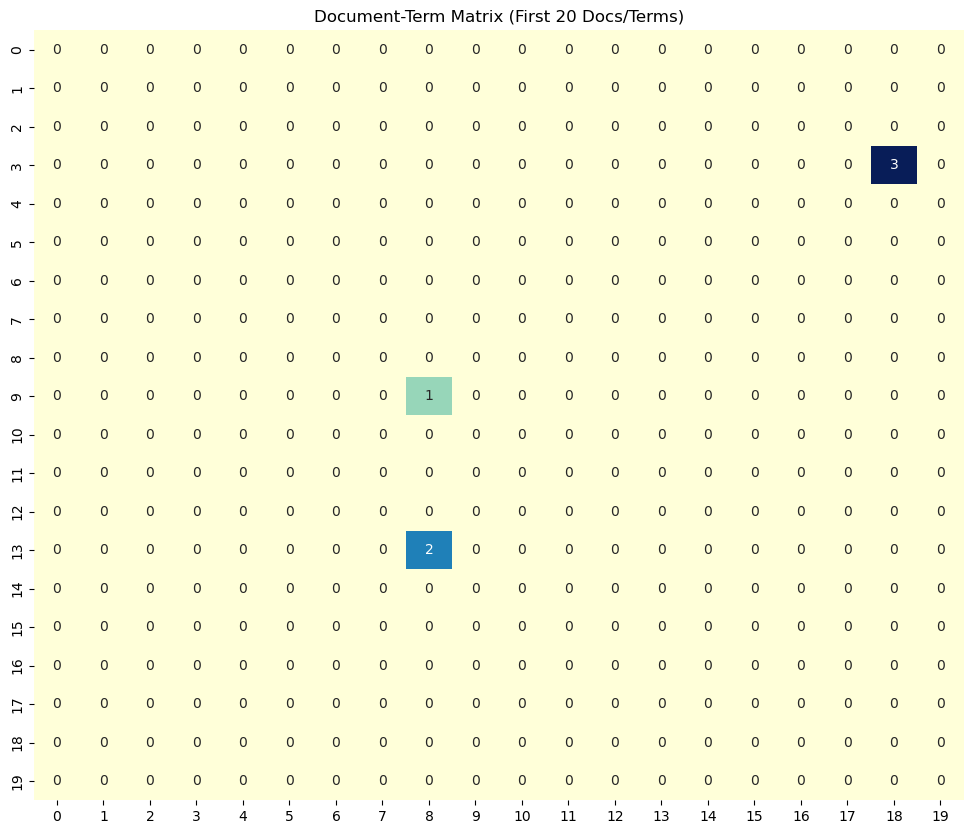

In [8]:
# Visualize the first 20x20 part of the matrix
plt.figure(figsize=(12, 10))
sns.heatmap(X_counts[:20, :20].toarray(), cmap='YlGnBu', annot=True, cbar=False)
plt.title('Document-Term Matrix (First 20 Docs/Terms)')
plt.show()

### 6. Attribute Transformation: Term Frequencies
Let's find out which words are most common across all the posts. This can reveal the main topics being discussed.

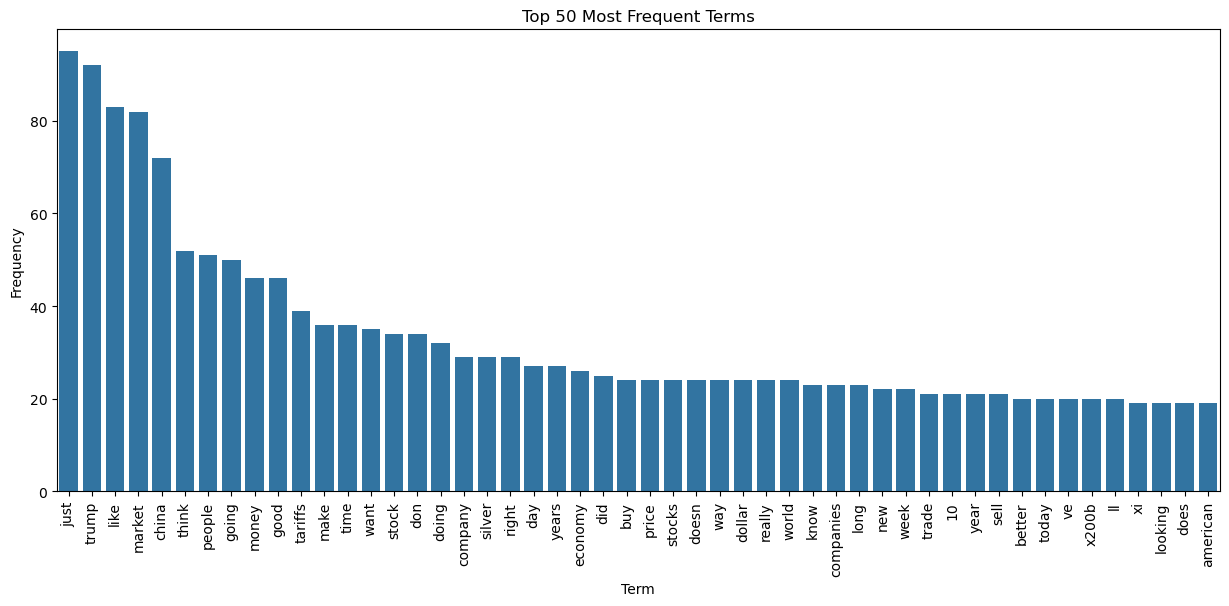

In [9]:
# Sum up the counts of each word across all documents
term_frequencies = np.asarray(X_counts.sum(axis=0))[0]

# Create a DataFrame with terms and their frequencies
term_freq_df = pd.DataFrame({
    'Term': count_vect.get_feature_names_out(), 
    'Frequency': term_frequencies
})

# Sort by frequency to find the most common words
term_freq_df_sorted = term_freq_df.sort_values(by='Frequency', ascending=False)

# Plot the top 50 most frequent terms
plt.figure(figsize=(15, 6))
sns.barplot(x='Term', y='Frequency', data=term_freq_df_sorted.head(50))
plt.xticks(rotation=90)
plt.title('Top 50 Most Frequent Terms')
plt.show()

#### Log Transformation
The frequency distribution is heavily skewed. Applying a log transformation helps to visualize the differences between less frequent words more clearly.

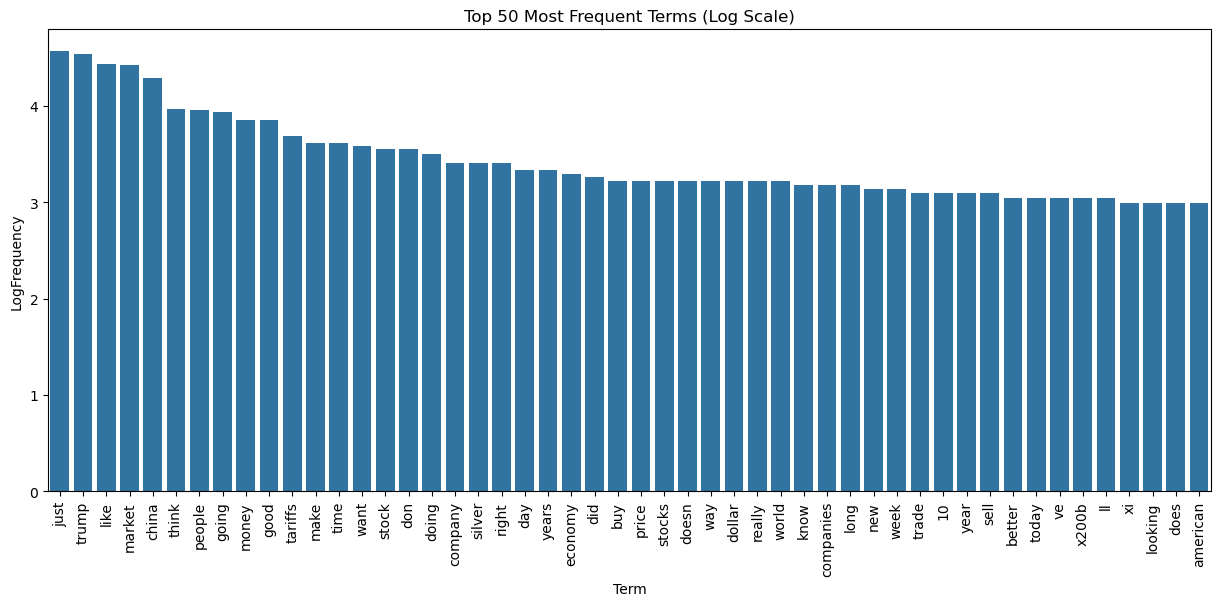

In [10]:
# Apply a log transformation to the frequency
# We add 1 to avoid taking the log of zero
term_freq_df_sorted['LogFrequency'] = term_freq_df_sorted['Frequency'].apply(lambda x: math.log(x + 1))

# Plot the log-transformed frequencies of the top 50 terms
plt.figure(figsize=(15, 6))
sns.barplot(x='Term', y='LogFrequency', data=term_freq_df_sorted.head(50))
plt.xticks(rotation=90)
plt.title('Top 50 Most Frequent Terms (Log Scale)')
plt.show()

---
End of Phase 1 process on the new dataset.